# Train Neural Net
> NN training notebook

### To-do
---
- Early stopping
- Repeats
- Rename `epochs` ---> `max_epochs`
- "Best model" saving after training and selecting best model using some kind of criteria:
```python
import pickle
file_name = '/tmp/mymodel.pkl'
# Save
with open(file_name, 'wb') as f:
    pickle.dump(net, f)
# Load it back when needed
with open(file_name, 'rb') as f:
    new_net = pickle.load(f)
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#For running in JupyterHub:
import os
if os.path.basename(os.getcwd())!='P003':
    print('Not in /P003 folder, changing directory to P003')
    lib_path = os.path.expanduser(os.path.relpath('~/images/codesDIR/datathon2020/P003'))
    os.chdir(lib_path)

Not in /P003 folder, changing directory to P003


In [3]:
import torch, numpy as np, matplotlib.pyplot as plt

import matplotlib
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
# matplotlib.rcParams['font.size']= 22 # use for presentation

In case if you want to use CUDA-enabled GPU

- the for using GPU is not yet complete, but could still work.
- Need to implement mini-batch
- Right now tensors are copied to GPU from the beginning, which won't work for large datasets as we will fill up the GPU memory. But this way is faster as we don't spend time copying the tensors between devices.

In [5]:
# !nvidia-smi

**choose your GPU device here**

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
#     device = torch.device('cuda:3')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cuda


## Persistence

In [17]:
with open('persistence_T18.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
lead_time = persistence['lead_time']
print('Persistence:',persistence)

Persistence: {'lead_time': 18, 'Persistence_Euclidean': 0.10196654967828511, 'Persistence_MSE': 0.20393309935657022, 'Persistence_MAE': 0.3105751548586914}


## Training

`nn` module implements these networks (not the same as torch.nn):
- `fcNet` : fully-connected neural network, linear layer as a final layer (a.k.a. linear combiner)
    - e.g. Initialise network with two (hidden) layers, with dimensions `[8, 4]`
    ```python
model = fcNet(input_dim, layer_dims=[8,4], output_dim=1)
Y = model(x)
```
- `diffNet` : difference network. `diffNet(x,Y0) = Y0 + fcNet(x)`
    - e.g. Init. diff. net with 3 hidden layers, with dim-s `[16,8,4]`
    ```python
model = diffNet(input_dim, layer_dims=[16,8,4], output_dim=1)
Y = model(x, Y0)
```

In [7]:
from torch.nn import MSELoss, L1Loss

In [13]:
# Neural network implementations: fcNet, diffNet
from src.nnets import fcNet, diffNet, get_model, train_model
from src.utils import mse, lagged_xcorr

In [12]:
# Path for Datasets:
# all preprocessed data will be saved in `data_path`
data_path = os.path.relpath('../../../dataDIR/'+'preprocessed_linearinterp_avgmodels')
print(f'> Preprocessed data is from `{data_path}`\n')
!ls $data_path

> Preprocessed data is from `../../../dataDIR/preprocessed_linearinterp_avgmodels`

test_preprocessed_diff20.npy	  train_preprocessed_diff20.npy
test_preprocessed_diff40.npy	  train_preprocessed_diff40.npy
test_preprocessed_diff80.npy	  train_preprocessed_diff80.npy
test_preprocessed_naivewin20.npy  train_preprocessed_naivewin20.npy
test_preprocessed_naivewin40.npy  train_preprocessed_naivewin40.npy
test_preprocessed_naivewin80.npy  train_preprocessed_naivewin80.npy


### Naive Window (diff net)

In [121]:
window_size = 80 # 20, 40, 80

# Training data
train_fname = os.path.join(data_path,f'train_preprocessed_naivewin{window_size}.npy')
test_fname = os.path.join(data_path,f'test_preprocessed_naivewin{window_size}.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')


x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')

Shapes
train: torch.Size([29371, 81]) torch.float32,
test: torch.Size([1546, 81]) torch.float32

Training x torch.Size([29371, 79]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 79]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])



In [159]:
# Network size:
input_dim = x.shape[1]
layer_dims = [512,512,512,512,512]
dropout_p = [.2] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1

# Training parameters
repeat = 1       # number of training runs per configuration
learning_rate = 0.001 # default for Adam
epochs = 500    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 0.20620745420455933, test_loss: 0.20567120611667633
epoch 50> train_loss: 0.1477179080247879, test_loss: 0.14891602098941803
epoch 100> train_loss: 0.11733482778072357, test_loss: 0.15700361132621765
epoch 150> train_loss: 0.0972994938492775, test_loss: 0.16380618512630463
epoch 200> train_loss: 0.08252616226673126, test_loss: 0.17069993913173676
epoch 250> train_loss: 0.07298874109983444, test_loss: 0.17349344491958618
epoch 300> train_loss: 0.06608467549085617, test_loss: 0.1769820600748062
epoch 350> train_loss: 0.060016825795173645, test_loss: 0.17855992913246155
epoch 400> train_loss: 0.057278089225292206, test_loss: 0.17950692772865295
epoch 450> train_loss: 0.05459994822740555, test_loss: 0.17971612513065338


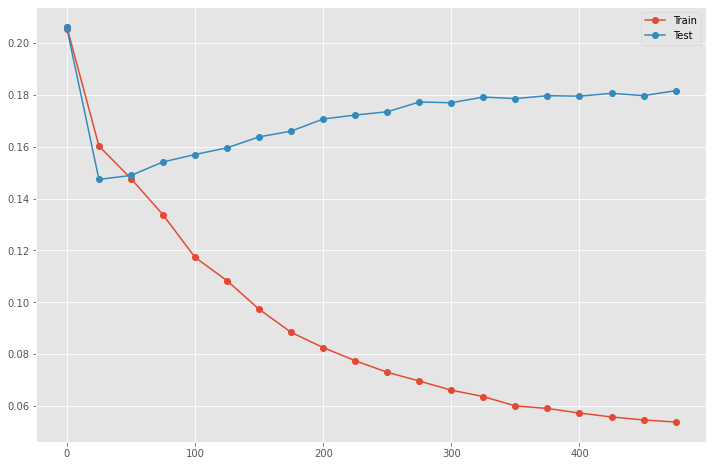

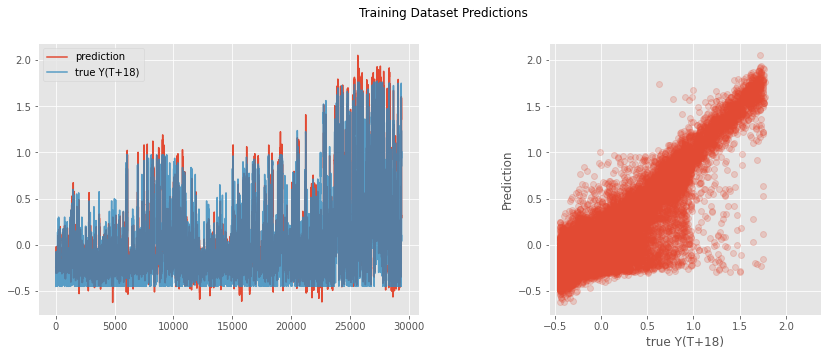

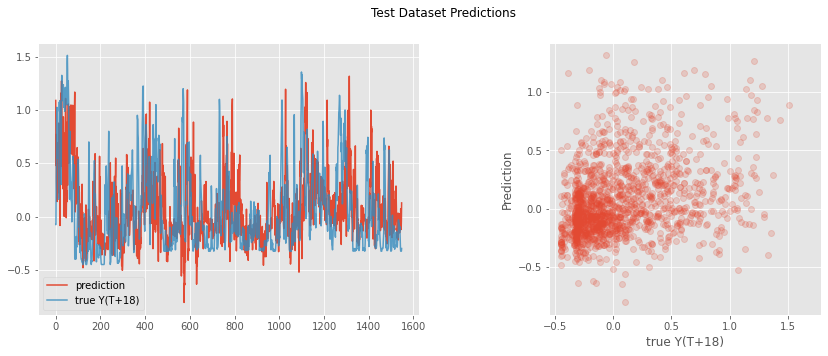

MSE loss (np): 0.17948969


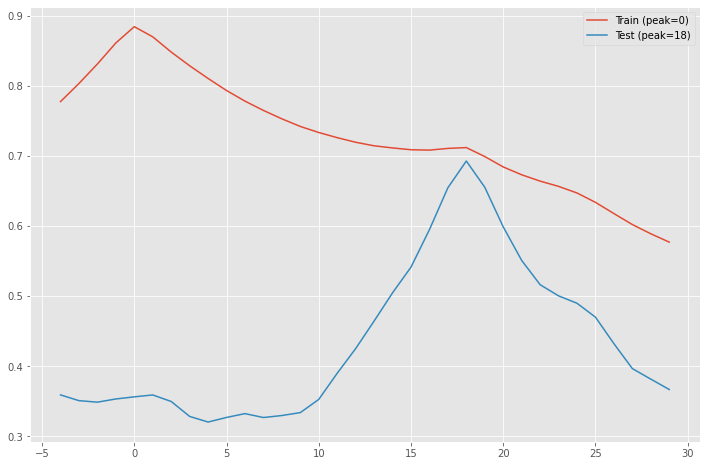

Train lag peak:0
Test lag peak:18


In [160]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Difference Windows

In [229]:
window_size = 80 # 20, 40, 80

# Training data
train_fname = os.path.join(data_path,f'train_preprocessed_diff{window_size}.npy')
test_fname = os.path.join(data_path,f'test_preprocessed_diff{window_size}.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')

x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')

Shapes
train: torch.Size([29371, 81]) torch.float32,
test: torch.Size([1546, 81]) torch.float32

Training x torch.Size([29371, 79]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 79]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])



In [230]:
# Network size:
input_dim = x.shape[1]
layer_dims = [256 for k in range(6)]
dropout_p = [.1] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1

# Training parameters
repeat = 1       # number of training runs per configuration
learning_rate = 0.001 # default for Adam
epochs = 500    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

In [231]:
from src.nnets import weights_init_kaiming_fanin, weights_init_kaiming_fanout

epoch 0> train_loss: 0.20452874898910522, test_loss: 0.20252065360546112
epoch 50> train_loss: 0.14065849781036377, test_loss: 0.1535004824399948
epoch 100> train_loss: 0.10479231923818588, test_loss: 0.18862563371658325
epoch 150> train_loss: 0.0810176357626915, test_loss: 0.20307563245296478
epoch 200> train_loss: 0.06420788913965225, test_loss: 0.2189975529909134
epoch 250> train_loss: 0.052814919501543045, test_loss: 0.23318162560462952
epoch 300> train_loss: 0.04447074979543686, test_loss: 0.22825202345848083
epoch 350> train_loss: 0.051716603338718414, test_loss: 0.2346705198287964
epoch 400> train_loss: 0.03383439779281616, test_loss: 0.22460448741912842
epoch 450> train_loss: 0.02939697541296482, test_loss: 0.22519347071647644


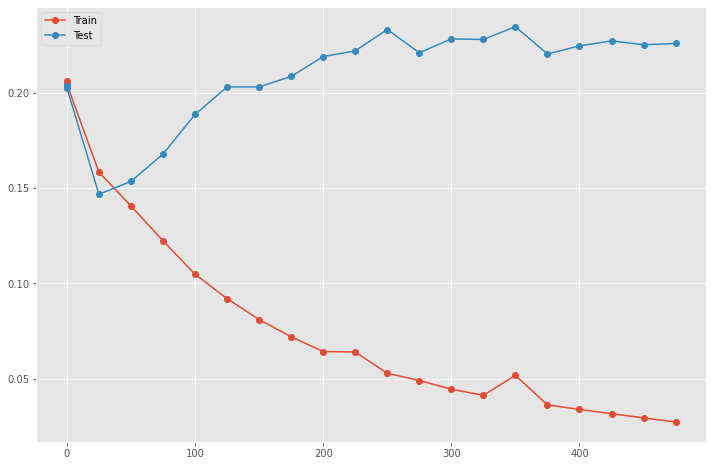

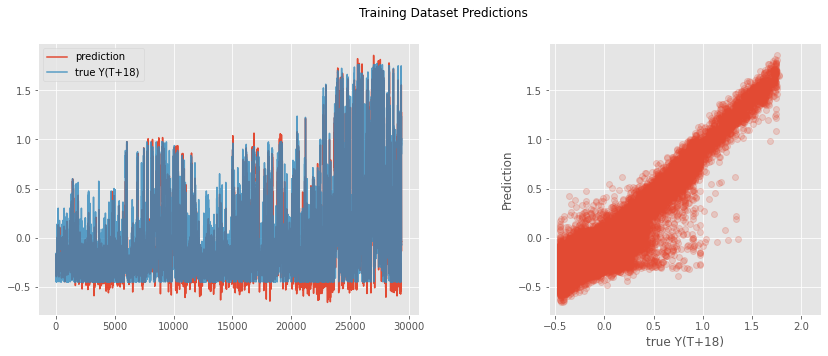

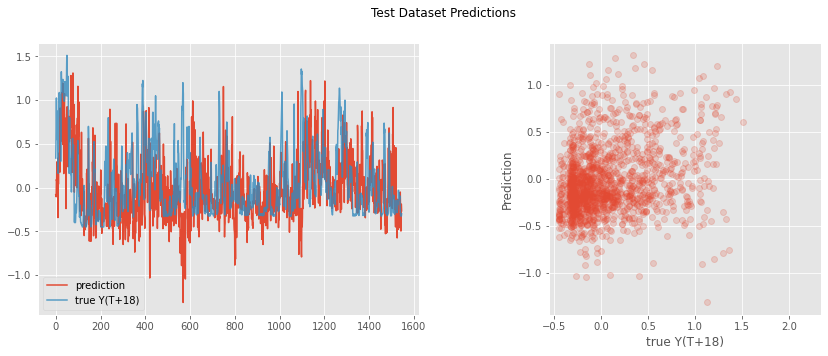

MSE loss (np): 0.22589524


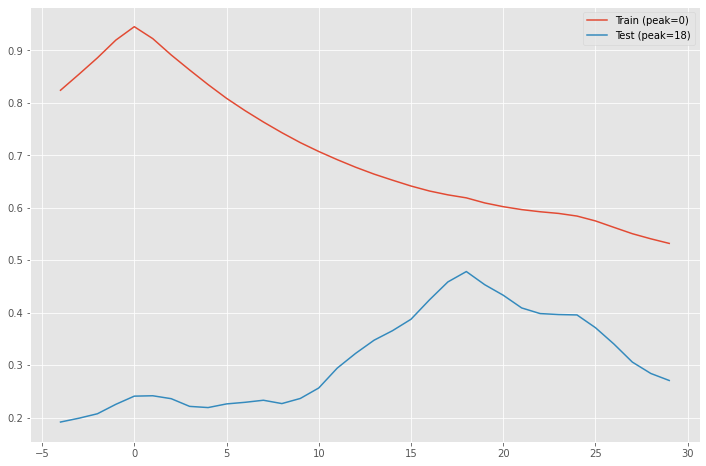

Train lag peak:0
Test lag peak:18


In [232]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
scheduler =None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)
# net.apply(weights_init_kaiming_fanin)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Difference with step size=Lead_time

In [ ]:
# # Training data
# with open('train_preprocessed_stepdiff51.npy', 'rb') as f:
#     X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
# with open('test_preprocessed_stepdiff51.npy', 'rb') as f:
#     X_test = torch.from_numpy(np.load(f).astype(np.float32))
# print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
#                                                   X_test.shape, X_test.dtype))

# x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
# Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
# y = X_train[:,:1].to(device) # Y(T+5)

# print(f'Training x {x.shape}')


# x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
# Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
# y_test = X_test[:,:1].to(device) # Y(T+5)

# print(f'x_test {x_test.shape}')

Shapes
train: torch.Size([574, 48]) torch.float32,
test: torch.Size([247, 48]) torch.float32
Training x torch.Size([574, 46])
x_test torch.Size([247, 46])


In [ ]:
# # Network size:
# input_dim = x.shape[1]
# layer_dims = [128,64,64,64]
# dropout_p = [.25] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
# output_dim = 1
# # Training parameters
# repeat = 1       # number of training runs per configuration

# learning_rate = 0.001 # default for Adam
# epochs = 1000    # total number of training epochs == training iterations for the batch
# loss_func = MSELoss(reduction='mean')
# test_intervl =25 # collect loss every "test_intervl" iter-n
# print_times=10   # number of times to print loss to the terminal

# # Learning Rate policy:
# step_size=100 # drop the learning rate every "step_size" iter-s
# gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# # autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.3647732734680176, test_loss: 1.4342290163040161
epoch 100> train_loss: 0.21828588843345642, test_loss: 1.0863865613937378
epoch 200> train_loss: 0.08807011693716049, test_loss: 1.062011480331421
epoch 300> train_loss: 0.06576290726661682, test_loss: 1.0406540632247925
epoch 400> train_loss: 0.05077158287167549, test_loss: 1.0375133752822876
epoch 500> train_loss: 0.04849392920732498, test_loss: 1.0324198007583618
epoch 600> train_loss: 0.04602380469441414, test_loss: 1.0342999696731567
epoch 700> train_loss: 0.04545048251748085, test_loss: 1.03348708152771
epoch 800> train_loss: 0.04371201619505882, test_loss: 1.0326915979385376
epoch 900> train_loss: 0.04342270642518997, test_loss: 1.0333507061004639


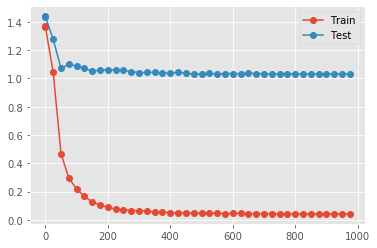

In [ ]:
# net, opt = get_model('diffNet','Adam',
#                      model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
#                                   'dropout_p':dropout_p},
#                     solver_kwargs={'lr':learning_rate},device=device)

# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
#                                                   ((x_test,Y0_test), y_test),
#                                                   opt, loss_func, epochs=epochs, 
#                                                   scheduler=scheduler)

# plt.plot(train_epochs,train_loss,'o-',label='Train')
# plt.plot(train_epochs,test_loss,'o-',label='Test')
# plt.legend();

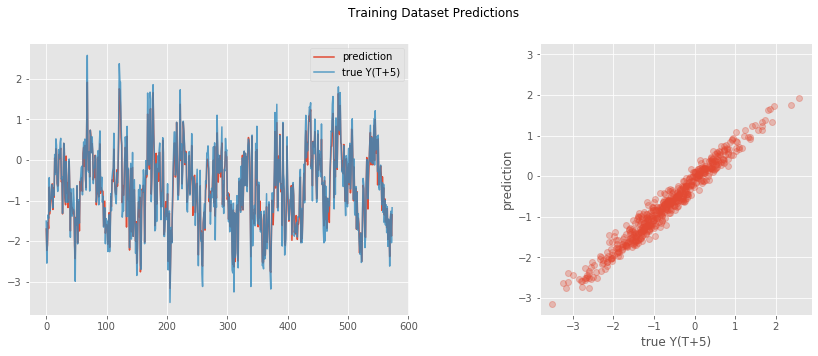

In [ ]:
# net.eval()
# pred = net(x,Y0).detach().cpu().numpy()
# target = y.cpu().numpy()
# _,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
# axs[0].plot(pred,label='prediction')
# axs[0].plot(target,label='true Y(T+5)',alpha=.8)
# axs[0].legend()
# axs[1].plot(target,pred,'o',alpha=.3)
# axs[1].set_xlabel('true Y(T+5)')
# axs[1].set_ylabel('prediction')
# axs[1].axis('square')

# plt.suptitle('Training Dataset Predictions');

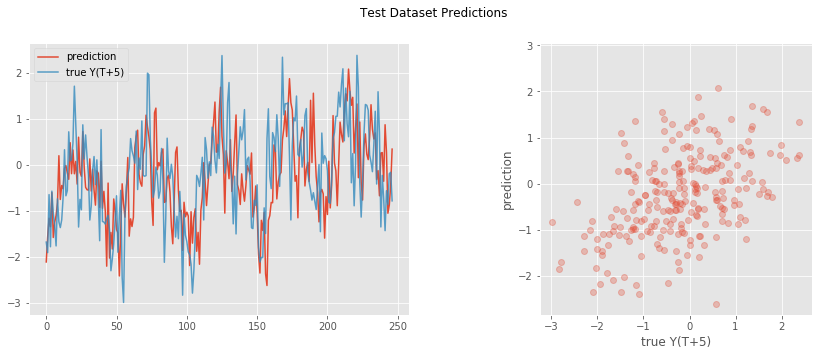

In [ ]:
# net.eval()
# pred_test = net(x_test,Y0_test).detach().cpu().numpy()
# target_test = y_test.cpu().numpy()
# _,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
# axs[0].plot(pred_test,label='prediction')
# axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
# axs[0].legend()
# axs[1].plot(target_test,pred_test,'o',alpha=.3)
# axs[1].set_xlabel('true Y(T+5)')
# axs[1].set_ylabel('prediction')
# axs[1].axis('square')
# plt.suptitle('Test Dataset Predictions');

Train lag peak:0
Test lag peak:5


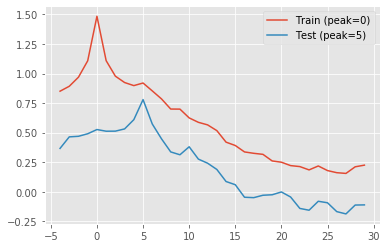

In [ ]:
# from src.utils import lagged_xcorr

# net.eval()
# train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().cpu().numpy().ravel(), 
#                                         y.cpu().numpy().ravel())
# test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().cpu().numpy().ravel(),
#                                       y_test.cpu().numpy().ravel())
# lag_min = -5
# lag_max = 30

# train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
# test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

# train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
# test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

# plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
# plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

# plt.legend();
# print(f'Train lag peak:{train_peak_lag}')
# print(f'Test lag peak:{test_peak_lag}')

### Momentum and Force

In [ ]:
# # Training data
# with open('train_preprocessed_mntfrcwin51.npy', 'rb') as f:
#     X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
# with open('test_preprocessed_mntfrcwin51.npy', 'rb') as f:
#     X_test = torch.from_numpy(np.load(f).astype(np.float32))
# print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
#                                                   X_test.shape, X_test.dtype))

# x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
# Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
# y = X_train[:,:1].to(device) # Y(T+5)

# print(f'Training x {x.shape}')


# x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
# Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
# y_test = X_test[:,:1].to(device) # Y(T+5)

# print(f'x_test {x_test.shape}')

Shapes
train: torch.Size([574, 125]) torch.float32,
test: torch.Size([247, 125]) torch.float32
Training x torch.Size([574, 123])
x_test torch.Size([247, 123])


In [ ]:
# # Network size:
# input_dim = x.shape[1]
# layer_dims = [128,64,64,64]
# dropout_p = [.3] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
# output_dim = 1
# # Training parameters
# repeat = 1       # number of training runs per configuration

# learning_rate = 0.001 # default for Adam
# epochs = 10000    # total number of training epochs == training iterations for the batch
# loss_func = MSELoss(reduction='mean')
# test_intervl =25 # collect loss every "test_intervl" iter-n
# print_times=10   # number of times to print loss to the terminal

# # Learning Rate policy:
# step_size=100 # drop the learning rate every "step_size" iter-s
# gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# # autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.3617316484451294, test_loss: 1.4322643280029297
epoch 1000> train_loss: 0.08083803206682205, test_loss: 1.0823395252227783
epoch 2000> train_loss: 0.08065631240606308, test_loss: 1.0821999311447144
epoch 3000> train_loss: 0.08064273744821548, test_loss: 1.082207202911377
epoch 4000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 5000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 6000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 7000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 8000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 9000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377


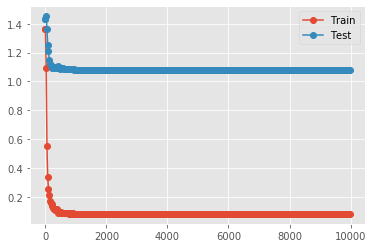

In [ ]:
# net, opt = get_model('diffNet','Adam',
#                      model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
#                                   'dropout_p':dropout_p},
#                     solver_kwargs={'lr':learning_rate},device=device)

# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# # scheduler = None
# train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
#                                                   ((x_test,Y0_test), y_test),
#                                                   opt, loss_func, epochs=epochs, 
#                                                   scheduler=scheduler)

# plt.plot(train_epochs,train_loss,'o-',label='Train')
# plt.plot(train_epochs,test_loss,'o-',label='Test')
# plt.legend();

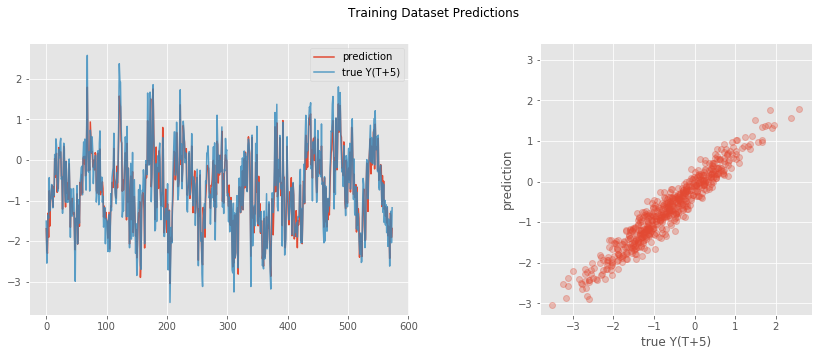

In [ ]:
# net.eval()
# pred = net(x,Y0).detach().cpu().numpy()
# target = y.cpu().numpy()
# _,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
# axs[0].plot(pred,label='prediction')
# axs[0].plot(target,label='true Y(T+5)',alpha=.8)
# axs[0].legend()
# axs[1].plot(target,pred,'o',alpha=.3)
# axs[1].set_xlabel('true Y(T+5)')
# axs[1].set_ylabel('prediction')
# axs[1].axis('square')

# plt.suptitle('Training Dataset Predictions');

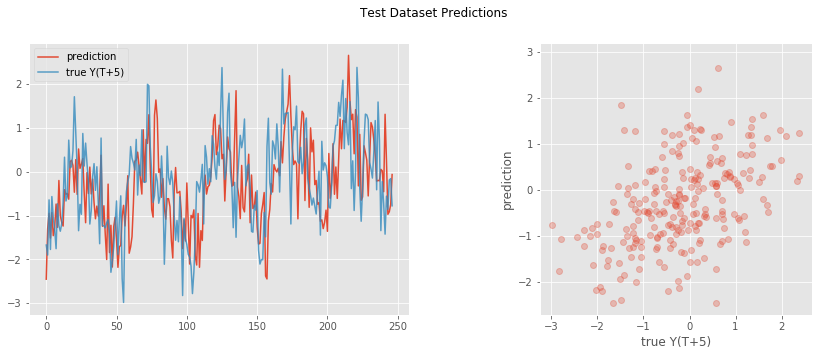

In [ ]:
# net.eval()
# pred_test = net(x_test,Y0_test).detach().cpu().numpy()
# target_test = y_test.cpu().numpy()
# _,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
# axs[0].plot(pred_test,label='prediction')
# axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
# axs[0].legend()
# axs[1].plot(target_test,pred_test,'o',alpha=.3)
# axs[1].set_xlabel('true Y(T+5)')
# axs[1].set_ylabel('prediction')
# axs[1].axis('square')
# plt.suptitle('Test Dataset Predictions');

Train lag peak:0
Test lag peak:5


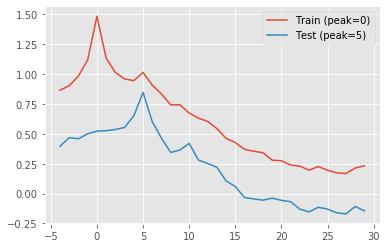

In [ ]:
# from src.utils import lagged_xcorr

# net.eval()
# train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().cpu().numpy().ravel(), 
#                                         y.cpu().numpy().ravel())
# test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().cpu().numpy().ravel(),
#                                       y_test.cpu().numpy().ravel())
# lag_min = -5
# lag_max = 30

# train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
# test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

# train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
# test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

# plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
# plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

# plt.legend();
# print(f'Train lag peak:{train_peak_lag}')
# print(f'Test lag peak:{test_peak_lag}')